## **Importing Libraries**

In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import *
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, KFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from sklearn.preprocessing import MinMaxScaler
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from keras.engine import Layer
from keras.engine import InputSpec
from keras.objectives import categorical_crossentropy
from keras.objectives import sparse_categorical_crossentropy
import seaborn as sns
# import gplearn
# from gplearn.genetic import SymbolicTransformer
# from gplearn.functions import make_function

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## **Importing Data,Preliminary Analysis and Basic Feature Engineering**

In [2]:
# Importing the data and checking

df=pd.read_csv("../input/Power-Networks-LCL.csv")
df.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0.0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0.0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0.0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0.0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0.0,ACORN-A,Affluent


In [3]:
# Checking the count for each household

df["LCLid"].value_counts()

MAC000018    39081
MAC000020    39078
MAC000021    39078
MAC000022    39071
MAC000019    39070
MAC000033    39070
MAC000034    39069
MAC000032    39068
MAC000023    39068
MAC000027    39068
MAC000030    39066
MAC000025    39064
MAC000026    39064
MAC000029    39063
MAC000024    39026
MAC000035    39023
MAC000006    36460
MAC000003    35468
MAC000028    32157
MAC000004    31676
MAC000013    29613
MAC000008    26012
MAC000009    25237
MAC000010    25048
MAC000007    25045
MAC000012    24669
MAC000002    24157
MAC000011    23704
MAC000016    19523
MAC000036    16175
Name: LCLid, dtype: int64

In [4]:
df["stdorToU"].value_counts()

Std    999971
Name: stdorToU, dtype: int64

In [5]:
df["Acorn_grouped"].value_counts()

Affluent       441311
Adversity      365341
Comfortable    154251
ACORN-U         39068
Name: Acorn_grouped, dtype: int64

In [6]:
# Making sepearte features for  Day, Month, Hour and Minute

import datetime
df["DateTime"]=pd.to_datetime(df["DateTime"])

df["Day"]=df["DateTime"].dt.day
df["Month"]=df["DateTime"].dt.month
df["Year"]=df["DateTime"].dt.year
df["Hour"]=df["DateTime"].dt.hour
df["Minute"]=df["DateTime"].dt.minute

In [7]:
tophouses=df[(df.LCLid=="MAC000018") | (df.LCLid=="MAC000020") | (df.LCLid=="MAC000021")]

### **Plots of the Mean Hourly, Daily and Monthly electricty usage of the top 3 households**

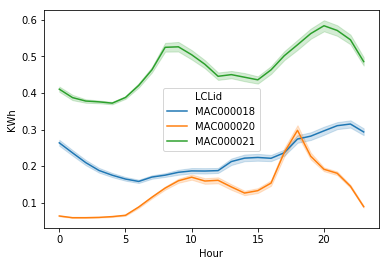

In [8]:
sns.lineplot(x="Hour",y="KWh",data=tophouses,estimator="mean",hue="LCLid")

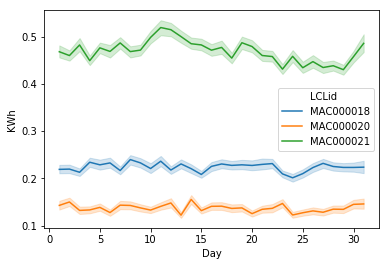

In [9]:
sns.lineplot(x="Day",y="KWh",data=tophouses,estimator="mean",hue="LCLid")

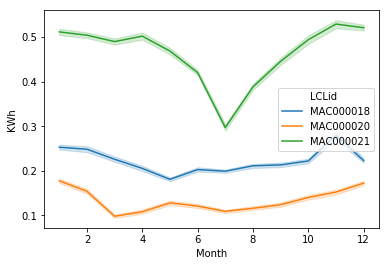

In [10]:
sns.lineplot(x="Month",y="KWh",data=tophouses,estimator="mean",hue="LCLid")

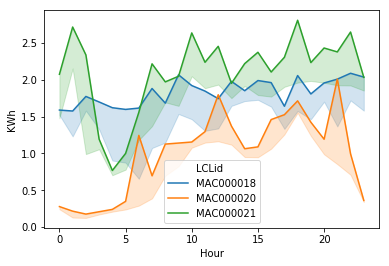

In [11]:
sns.lineplot(x="Hour",y="KWh",data=tophouses,estimator="max",hue="LCLid")

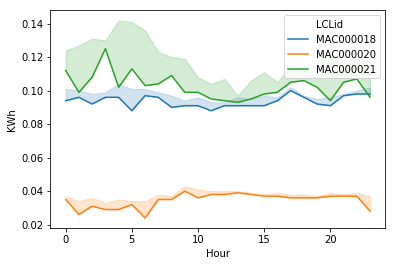

In [12]:
sns.lineplot(x="Hour",y="KWh",data=tophouses,estimator="min",hue="LCLid")

In [13]:
tophouse1=df[df["LCLid"]=="MAC000018"]
tophouse1energy=tophouse1["KWh"].values
print(tophouse1["KWh"].max())
print(tophouse1["KWh"].min())

2.0880001
0.08800000000000001


In [14]:
# Defining custom function for Min-Max Scaling of the data
def min_max_transfer(ts, min_value, max_value, range_needed=(-1,1)):
    ts_std = (ts - min_value) / (max_value - min_value)

    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]
    
training_set_scaled=min_max_transfer(tophouse1energy, tophouse1["KWh"].min(), tophouse1["KWh"].max(), range_needed=(-1,1))

In [15]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (-1, 1))
#training_set_scaled = sc.fit_transform(np.array(tophouse1energy).reshape(-1,1))
tophouse1["Scaled"]=training_set_scaled
#trainingsetscaled=list(training_set_scaled)
listtrain=tophouse1["Scaled"].values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### **Formatting the data for time-series (Taking 10 time-steps for predicting the 11th time-step)**

In [16]:
X_train = []
y_train = []
for i in range(10, 39081):
    X_train.append(listtrain[i-10:i])
    y_train.append(listtrain[i])
X_train, y_train = np.array(X_train), np.array(y_train)
#final=pd.DataFrame(X_train)

### **Making extra Features for Auxillary Input to LSTM**

In [17]:
def petrosian_fd(x):
    """Petrosian fractal dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    Returns
    -------
    pfd : float
        Petrosian fractal dimension
    Notes
    -----
    The Petrosian algorithm can be used to provide a fast computation of
    the FD of a signal by translating the series into a binary sequence.
    The Petrosian fractal dimension of a time series :math:`x` is defined by:
    .. math:: \dfrac{log_{10}(N)}{log_{10}(N) +
       log_{10}(\dfrac{N}{N+0.4N_{\Delta}})}
    where :math:`N` is the length of the time series, and
    :math:`N_{\Delta}` is the number of sign changes in the binary sequence.
    Original code from the pyrem package by Quentin Geissmann.
    References
    ----------
    .. [1] A. Petrosian, Kolmogorov complexity of finite sequences and
       recognition of different preictal EEG patterns, in , Proceedings of the
       Eighth IEEE Symposium on Computer-Based Medical Systems, 1995,
       pp. 212-217.
    .. [2] Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
       the computation of EEG biomarkers for dementia." 2nd International
       Conference on Computational Intelligence in Medicine and Healthcare
       (CIMED2005). 2005.
    Examples
    --------
    Petrosian fractal dimension.
        >>> import numpy as np
        >>> from entropy import petrosian_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(petrosian_fd(x))
            1.0505
    """
    n = len(x)
    # Number of sign changes in the first derivative of the signal
    diff = np.ediff1d(x)
    N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))


def katz_fd(x):
    """Katz Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    Returns
    -------
    kfd : float
        Katz fractal dimension
    Notes
    -----
    The Katz Fractal dimension is defined by:
    .. math:: FD_{Katz} = \dfrac{log_{10}(n)}{log_{10}(d/L)+log_{10}(n)}
    where :math:`L` is the total length of the time series and :math:`d`
    is the Euclidean distance between the first point in the
    series and the point that provides the furthest distance
    with respect to the first point.
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    References
    ----------
    .. [1] Esteller, R. et al. (2001). A comparison of waveform fractal
           dimension algorithms. IEEE Transactions on Circuits and Systems I:
           Fundamental Theory and Applications, 48(2), 177-183.
    .. [2] Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
           the computation of EEG biomarkers for dementia." 2nd International
           Conference on Computational Intelligence in Medicine and Healthcare
           (CIMED2005). 2005.
    Examples
    --------
    Katz fractal dimension.
        >>> import numpy as np
        >>> from entropy import katz_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(katz_fd(x))
            5.1214
    """
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

@jit('UniTuple(float64, 2)(float64[:], float64[:])', nopython=True)
def _linear_regression(x, y):
    """Fast linear regression using Numba.
    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables
    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept


@jit('i8[:](f8, f8, f8)', nopython=True)
def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.
    Used for detrended fluctuation analysis (DFA).
    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.
    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)
    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

@jit('float64(float64[:], int32)')
def _higuchi_fd(x, kmax):
    """Utility function for `higuchi_fd`.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    """Higuchi Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    kmax : int
        Maximum delay/offset (in number of samples).
    Returns
    -------
    hfd : float
        Higuchi Fractal Dimension
    Notes
    -----
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    The `higuchi_fd` function uses Numba to speed up the computation.
    References
    ----------
    .. [1] Higuchi, Tomoyuki. "Approach to an irregular time series on the
       basis of the fractal theory." Physica D: Nonlinear Phenomena 31.2
       (1988): 277-283.
    Examples
    --------
    Higuchi Fractal Dimension
        >>> import numpy as np
        >>> from entropy import higuchi_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(higuchi_fd(x))
            2.051179
    """
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

In [18]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    """Permutation Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    Notes
    -----
    The permutation entropy is a complexity measure for time-series first
    introduced by Bandt and Pompe in 2002 [1]_.
    The permutation entropy of a signal :math:`x` is defined as:
    .. math:: H = -\sum p(\pi)log_2(\pi)
    where the sum runs over all :math:`n!` permutations :math:`\pi` of order
    :math:`n`. This is the information contained in comparing :math:`n`
    consecutive values of the time series. It is clear that
    :math:`0 ≤ H (n) ≤ log_2(n!)` where the lower bound is attained for an
    increasing or decreasing sequence of values, and the upper bound for a
    completely random system where all :math:`n!` possible permutations appear
    with the same probability.
    The embedded matrix :math:`Y` is created by:
    .. math:: y(i)=[x_i,x_{i+delay}, ...,x_{i+(order-1) * delay}]
    .. math:: Y=[y(1),y(2),...,y(N-(order-1))*delay)]^T
    References
    ----------
    .. [1] Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a
           natural complexity measure for time series." Physical review letters
           88.17 (2002): 174102.
    Examples
    --------
    1. Permutation entropy with order 2
        >>> from entropy import perm_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value in bit between 0 and log2(factorial(order))
        >>> print(perm_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> from entropy import perm_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(perm_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
    """Spectral Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    sf : float
        Sampling frequency
    method : str
        Spectral estimation method ::
        'fft' : Fourier Transform (via scipy.signal.periodogram)
        'welch' : Welch periodogram (via scipy.signal.welch)
    nperseg : str or int
        Length of each FFT segment for Welch method.
        If None, uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.
    Returns
    -------
    se : float
        Spectral Entropy
    Notes
    -----
    Spectral Entropy is defined to be the Shannon Entropy of the Power
    Spectral Density (PSD) of the data:
    .. math:: H(x, sf) =  -\sum_{f=0}^{f_s/2} PSD(f) log_2[PSD(f)]
    Where :math:`PSD` is the normalised PSD, and :math:`f_s` is the sampling
    frequency.
    References
    ----------
    .. [1] Inouye, T. et al. (1991). Quantification of EEG irregularity by
       use of the entropy of the power spectrum. Electroencephalography
       and clinical neurophysiology, 79(3), 204-210.
    Examples
    --------
    1. Spectral entropy of a pure sine using FFT
        >>> from entropy import spectral_entropy
        >>> import numpy as np
        >>> sf, f, dur = 100, 1, 4
        >>> N = sf * duration # Total number of discrete samples
        >>> t = np.arange(N) / sf # Time vector
        >>> x = np.sin(2 * np.pi * f * t)
        >>> print(np.round(spectral_entropy(x, sf, method='fft'), 2)
            0.0
    2. Spectral entropy of a random signal using Welch's method
        >>> from entropy import spectral_entropy
        >>> import numpy as np
        >>> np.random.seed(42)
        >>> x = np.random.rand(3000)
        >>> print(spectral_entropy(x, sf=100, method='welch'))
            9.939
    3. Normalized spectral entropy
        >>> print(spectral_entropy(x, sf=100, method='welch', normalize=True))
            0.995
    """
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se


def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    svd_e : float
        SVD Entropy
    Notes
    -----
    SVD entropy is an indicator of the number of eigenvectors that are needed
    for an adequate explanation of the data set. In other words, it measures
    the dimensionality of the data.
    The SVD entropy of a signal :math:`x` is defined as:
    .. math::
        H = -\sum_{i=1}^{M} \overline{\sigma}_i log_2(\overline{\sigma}_i)
    where :math:`M` is the number of singular values of the embedded matrix
    :math:`Y` and :math:`\sigma_1, \sigma_2, ..., \sigma_M` are the
    normalized singular values of :math:`Y`.
    The embedded matrix :math:`Y` is created by:
    .. math:: y(i)=[x_i,x_{i+delay}, ...,x_{i+(order-1) * delay}]
    .. math:: Y=[y(1),y(2),...,y(N-(order-1))*delay)]^T
    Examples
    --------
    1. SVD entropy with order 2
        >>> from entropy import svd_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value in bit between 0 and log2(factorial(order))
        >>> print(svd_entropy(x, order=2))
            0.762
    2. Normalized SVD entropy with order 3
        >>> from entropy import svd_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(svd_entropy(x, order=3, normalize=True))
            0.687
    """
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e


def _app_samp_entropy(x, order, metric='chebyshev', approximate=True):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    phi = np.zeros(2)
    r = 0.2 * np.std(x, axis=-1, ddof=1)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    if approximate:
        emb_data1 = _emb_data1
    else:
        emb_data1 = _emb_data1[:-1]
    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    # compute phi(order + 1, r)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    if approximate:
        phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
        phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
    else:
        phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
        phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


#@jit('f8(f8[:], i4, f8)', nopython=True)
def _numba_sampen(x, mm=2, r=0.2):
    """
    Fast evaluation of the sample entropy using Numba.
    """
    n = x.size
    n1 = n - 1
    mm += 1
    mm_dbld = 2 * mm

    # Define threshold
    r *= x.std()

    # initialize the lists
    run = [0] * n
    run1 = run[:]
    r1 = [0] * (n * mm_dbld)
    a = [0] * mm
    b = a[:]
    p = a[:]

    for i in range(n1):
        nj = n1 - i

        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - x[i]) < r:
                run[jj] = run1[jj] + 1
                m1 = mm if mm < run[jj] else run[jj]
                for m in range(m1):
                    a[m] += 1
                    if j < n1:
                        b[m] += 1
            else:
                run[jj] = 0
        for j in range(mm_dbld):
            run1[j] = run[j]
            r1[i + n * j] = run[j]
        if nj > mm_dbld - 1:
            for j in range(mm_dbld, nj):
                run1[j] = run[j]

    m = mm - 1

    while m > 0:
        b[m] = b[m - 1]
        m -= 1

    b[0] = n * n1 / 2
    a = np.array([float(aa) for aa in a])
    b = np.array([float(bb) for bb in b])
    p = np.true_divide(a, b)
    return -log(p[-1])


def app_entropy(x, order=2, metric='chebyshev'):
    """Approximate Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with
        :class:`~sklearn.neighbors.KDTree`. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    Returns
    -------
    ae : float
        Approximate Entropy.
    Notes
    -----
    Original code from the mne-features package.
    Approximate entropy is a technique used to quantify the amount of
    regularity and the unpredictability of fluctuations over time-series data.
    Smaller values indicates that the data is more regular and predictable.
    The value of :math:`r` is set to :math:`0.2 * std(x)`.
    Code adapted from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    1. Approximate entropy with order 2.
        >>> from entropy import app_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(app_entropy(x, order=2))
            2.075
    """
    phi = _app_samp_entropy(x, order=order, metric=metric, approximate=True)
    return np.subtract(phi[0], phi[1])


def sample_entropy(x, order=2, metric='chebyshev'):
    """Sample Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: `KDTree.valid_metrics`.
    Returns
    -------
    se : float
        Sample Entropy.
    Notes
    -----
    Sample entropy is a modification of approximate entropy, used for assessing
    the complexity of physiological time-series signals. It has two advantages
    over approximate entropy: data length independence and a relatively
    trouble-free implementation. Large values indicate high complexity whereas
    smaller values characterize more self-similar and regular signals.
    Sample entropy of a signal :math:`x` is defined as:
    .. math:: H(x, m, r) = -log\dfrac{C(m + 1, r)}{C(m, r)}
    where :math:`m` is the embedding dimension (= order), :math:`r` is
    the radius of the neighbourhood (default = :math:`0.2 * std(x)`),
    :math:`C(m + 1, r)` is the number of embedded vectors of length
    :math:`m + 1` having a Chebyshev distance inferior to :math:`r` and
    :math:`C(m, r)` is the number of embedded vectors of length
    :math:`m` having a Chebyshev distance inferior to :math:`r`.
    Note that if metric == 'chebyshev' and x.size < 5000 points, then the
    sample entropy is computed using a fast custom Numba script. For other
    metric types or longer time-series, the sample entropy is computed using
    a code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort (requires sklearn).
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    Examples
    --------
    1. Sample entropy with order 2.
        >>> from entropy import sample_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(sample_entropy(x, order=2))
            2.192
    2. Sample entropy with order 3 using the Euclidean distance.
        >>> from entropy import sample_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(sample_entropy(x, order=3, metric='euclidean'))
            2.725
    """
    x = np.asarray(x, dtype=np.float64)
    if metric == 'chebyshev' and x.size < 5000:
        return _numba_sampen(x, mm=order, r=0.2)
    else:
        phi = _app_samp_entropy(x, order=order, metric=metric,
                                approximate=False)
        return -np.log(np.divide(phi[1], phi[0]))

In [19]:
@jit('UniTuple(float64, 2)(float64[:], float64[:])', nopython=True)
def _linear_regression(x, y):
    """Fast linear regression using Numba.
    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables
    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept


@jit('i8[:](f8, f8, f8)', nopython=True)
def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.
    Used for detrended fluctuation analysis (DFA).
    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.
    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)
    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

@jit('f8(f8[:])', nopython=True)
def _dfa(x):
    """
    Utility function for detrended fluctuation analysis
    """
    N = len(x)
    nvals = _log_n(4, 0.1 * N, 1.2)
    walk = np.cumsum(x - x.mean())
    fluctuations = np.zeros(len(nvals))

    for i_n, n in enumerate(nvals):
        d = np.reshape(walk[:N - (N % n)], (N // n, n))
        ran_n = np.array([float(na) for na in range(n)])
        d_len = len(d)
        slope = np.empty(d_len)
        intercept = np.empty(d_len)
        trend = np.empty((d_len, ran_n.size))
        for i in range(d_len):
            slope[i], intercept[i] = _linear_regression(ran_n, d[i])
            y = np.zeros_like(ran_n)
            # Equivalent to np.polyval function
            for p in [slope[i], intercept[i]]:
                y = y * ran_n + p
            trend[i, :] = y
        # calculate standard deviation (fluctuation) of walks in d around trend
        flucs = np.sqrt(np.sum((d - trend) ** 2, axis=1) / n)
        # calculate mean fluctuation over all subsequences
        fluctuations[i_n] = flucs.sum() / flucs.size

    # Filter zero
    nonzero = np.nonzero(fluctuations)[0]
    fluctuations = fluctuations[nonzero]
    nvals = nvals[nonzero]
    if len(fluctuations) == 0:
        # all fluctuations are zero => we cannot fit a line
        dfa = np.nan
    else:
        dfa, _ = _linear_regression(np.log(nvals), np.log(fluctuations))
    return dfa


def detrended_fluctuation(x):
    """
    Detrended fluctuation analysis (DFA).
    Parameters
    ----------
    x : list or np.array
        One-dimensional time-series.
    Returns
    -------
    dfa : float
        the estimate alpha for the Hurst parameter:
        alpha < 1: stationary process similar to fractional Gaussian noise
        with H = alpha
        alpha > 1: non-stationary process similar to fractional Brownian
        motion with H = alpha - 1
    Notes
    -----
    Detrended fluctuation analysis (DFA) is used to find long-term statistical
    dependencies in time series.
    The idea behind DFA originates from the definition of self-affine
    processes. A process :math:`X` is said to be self-affine if the standard
    deviation of the values within a window of length n changes with the window
    length factor L in a power law:
    .. math:: \\text{std}(X, L * n) = L^H * \\text{std}(X, n)
    where :math:`\\text{std}(X, k)` is the standard deviation of the process
    :math:`X` calculated over windows of size :math:`k`. In this equation,
    :math:`H` is called the Hurst parameter, which behaves indeed very similar
    to the Hurst exponent.
    For more details, please refer to the excellent documentation of the nolds
    Python package by Christopher Scholzel, from which this function is taken:
    https://cschoel.github.io/nolds/nolds.html#detrended-fluctuation-analysis
    Note that the default subseries size is set to
    entropy.utils._log_n(4, 0.1 * len(x), 1.2)). The current implementation
    does not allow to manually specify the subseries size or use overlapping
    windows.
    The code is a faster (Numba) adaptation of the original code by Christopher
    Scholzel.
    References
    ----------
    .. [1] C.-K. Peng, S. V. Buldyrev, S. Havlin, M. Simons,
           H. E. Stanley, and A. L. Goldberger, “Mosaic organization of
           DNA nucleotides,” Physical Review E, vol. 49, no. 2, 1994.
    .. [2] R. Hardstone, S.-S. Poil, G. Schiavone, R. Jansen,
           V. V. Nikulin, H. D. Mansvelder, and K. Linkenkaer-Hansen,
           “Detrended fluctuation analysis: A scale-free view on neuronal
           oscillations,” Frontiers in Physiology, vol. 30, 2012.
    Examples
    --------
        >>> import numpy as np
        >>> from entropy import detrended_fluctuation
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(detrended_fluctuation(x))
            0.761647725305623
    """
    x = np.asarray(x, dtype=np.float64)
    return _dfa(x)

In [20]:
# Creation of the features

#def entropy_and_fractal_dim(x):
    #return [perm_entropy(x), svd_entropy(x), petrosian_fd(x), katz_fd(x),spectral_entropy(x,sf=100),detrended_fluctuation(x)]

def entropy_and_fractal_dim(x):
    return [perm_entropy(x), svd_entropy(x), petrosian_fd(x)]

features = []

for row in X_train:
    features.append(entropy_and_fractal_dim(row))
    
#features=pd.DataFrame(features)

In [21]:
# Reshaping the data for training

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Defining Attention Mechanism
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [23]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
# Defining Cyclic Learning Rate
clr = CyclicLR(base_lr=0.001, max_lr=0.002,
              step_size=300., mode='exp_range',
              gamma=0.99994)

### **Defining the model**

In [24]:
# Defining the function for the model

def model_lstm(input_shape, feat_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    feat = Input(shape=(feat_shape[1],))

    bi_lstm = Bidirectional(CuDNNLSTM(128, return_sequences=True), merge_mode='concat')(inp)
    bi_gru = Bidirectional(CuDNNGRU(64, return_sequences=True), merge_mode='concat')(bi_lstm)
    
    attention = Attention(input_shape[1])(bi_gru)
    
    # Concatenating Extra Features (Auxilary Input)
    x = concatenate([attention, feat], axis=1)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[inp, feat], outputs=x)
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    
    return model

In [25]:
# Converting train and extra fetaures into array fro training

X_train=np.array(X_train)
features=np.array(features)

In [26]:
# Defining the model

model = model_lstm(X_train.shape, features.shape)

### **Training the model**

In [27]:
# Here is where the training happens

# First, create a set of indexes of the 5 folds
splits = list(KFold(n_splits=5, shuffle=True, random_state=2019).split(X_train, y_train))
preds_val = []
y_val = []
# Then, iteract with each fold
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_feat, train_y, val_X, val_feat, val_y = X_train[train_idx], features[train_idx], y_train[train_idx], X_train[val_idx], features[val_idx], y_train[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape, features.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    #ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_mae', mode='min')
    # Train, train, train
    model.fit([train_X, train_feat], train_y, batch_size=128, epochs=50, validation_data=([val_X, val_feat], val_y), callbacks=[clr])
    # loads the best weights saved by the checkpoint
    #model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict([val_X, val_feat], batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 31256 samples, validate on 7815 samples
Epoch 1/50
31256/31256 [==============================] - 5s 148us/step - loss: 0.8078 - mean_absolute_error: 0.8832 - val_loss: 0.7742 - val_mean_absolute_error: 0.8663
Epoch 2/50
31256/31256 [==============================] - 3s 82us/step - loss: 0.7774 - mean_absolute_error: 0.8689 - val_loss: 0.7742 - val_mean_absolute_error: 0.8663
Epoch 3/50
31256/31256 [==============================] - 3s 82us/step - loss: 0.7774 - mean_absolute_error: 0.8689 - val_loss: 0.7742 - val_mean_absolute_error: 0.8663
Epoch 4/50
31256/31256 [==============================] - 3s 83us/step - loss: 0.7774 - mean_absolute_error: 0.8689 - val_loss: 0.7742 - val_mean_absolute_error: 0.8663
Epoch 5/50
31256/31256 [==============================] - 3s 82us/step - loss: 0.7774 - mean_absolute_error: 0.8689 - val_loss: 0.7742 - val_mean_absolute_error: 0.8663
Epoch 6/50
31256/31256 [==============================] - 3s 84us/step - loss: 0.7773 - 